# Water bodies segmentation with ResNet-34 based U-Net
This notebook shows the process of training a U-Net based model for water bodies segmentation on the [Satellite Images of Water Bodies](https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies), which consists of a collection of water body images captured by the Sentinel-2 Satellite. The dataset is split into a train and a validation set, each containing 224x224 RGB images.

Details about the architecture of the net are discussed below.

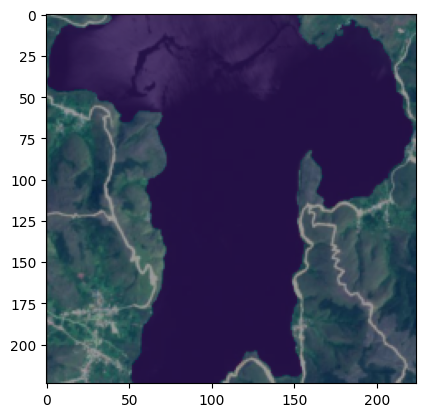

In [1]:
import albumentations as A
import torch
from torch.utils import data

from datasets import WaterSegmentationDataset, NUM_CLASSES
import utils


TRAIN_PERCENTAGE = 0.8
augmentations = [
                A.Blur(blur_limit=11),
                A.RandomBrightnessContrast(),
                A.Solarize(),
                A.RandomRotate90(p=1)
            ]
dataset = WaterSegmentationDataset("data/Water_Bodies_Dataset_Split/train_images",
                                   "data/Water_Bodies_Dataset_Split/train_masks", augmentations)
testset = WaterSegmentationDataset("data/Water_Bodies_Dataset_Split/valid_images",
                                   "data/Water_Bodies_Dataset_Split/valid_masks")
trainset, validationset = data.random_split(dataset, [TRAIN_PERCENTAGE, 1-TRAIN_PERCENTAGE])
device = torch.device("cuda:0")
utils.show_label(dataset, 1)

In [2]:
from torch.utils.data import DataLoader


BATCH_SIZE = 16

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
validation_loader = DataLoader(validationset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

The global pixel accuracy will be used to measure the performance of the model: for each predicted pixel, if the class it was predicted to belong is the same as the label for the pixel, the prediction is correct.

In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

import unet
from unet import UNet


def print_model_performace(model: UNet, dataset: WaterSegmentationDataset):
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for data in dataset:
            image, label = data[0].unsqueeze(0).to(device), data[1]
            prediction = model(image).cpu()
            accuracy += utils.pixel_accuracy(label, prediction)
    accuracy /= len(dataset)
    print(f"Accuracy: {accuracy:.5f}")


def train_model(
        segmenter: UNet,
        epochs: int,
        optimizer,
        criterion,
        scheduler_patience: int
    ) -> tuple[list, list, list, list]:
    STARTING_EPOCH = 25
    train_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    last_saved_epoch = -1
    scheduler = ReduceLROnPlateau(optimizer, patience=scheduler_patience)
    for epoch in range(1, epochs + 1):
        running_loss = 0
        running_accuracy = 0
        segmenter.train()
        for i, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = segmenter(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_accuracy += utils.pixel_accuracy(labels, outputs)
        val_loss = 0
        val_acc = 0
        segmenter.eval()
        with torch.no_grad():
            for i, data in enumerate(validation_loader):
                images, labels = data[0].to(device), data[1].to(device)
                outputs = segmenter(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += utils.pixel_accuracy(labels, outputs)
        val_loss = val_loss / len(validation_loader)
        epoch_loss = running_loss / len(train_loader)
        val_acc = val_acc / len(validation_loader)
        epoch_accuracy = running_accuracy / len(train_loader)
        train_loss.append(epoch_loss)
        validation_loss.append(val_loss)
        train_accuracy.append(epoch_accuracy)
        validation_accuracy.append(val_acc)
        scheduler.step(val_loss)
        if epoch >= STARTING_EPOCH and epoch - 5 > last_saved_epoch:
            previous_best_acc = max(validation_accuracy[:-2])
            if val_acc > previous_best_acc:
                acc = str(round(val_acc, 3)).replace(".", "")
                path = f"checkpoints/unet_{segmenter.input_size}_epoch{epoch}_{acc}.pth"
                torch.save(segmenter.state_dict(), path)
                last_saved_epoch = epoch
    return train_loss, validation_loss, train_accuracy, validation_accuracy

## The model architecture
The model follows a encoder-decoder architecture. The encoder follows the **ResNet-34** architecture, except that it doesn't have the fully-connected layer that does the classification. The decoder was built by connecting the components that make the **ResNet** architecture, but with layers that make the opposite operation to make the model as symmetric as possible: `Conv2d` were replaced with `ConvTranspose2d` layers; and the pooling layers with the `Upsample` layer. The extracted features from the different stages of the encoder were combined with the input of the equivalent stage in the decoder.
The size of the input should be specified during the creation of the model, so that the mask it creates during the decoding process matches the input's dimensions. Also, the input size should be divisible by *32*.

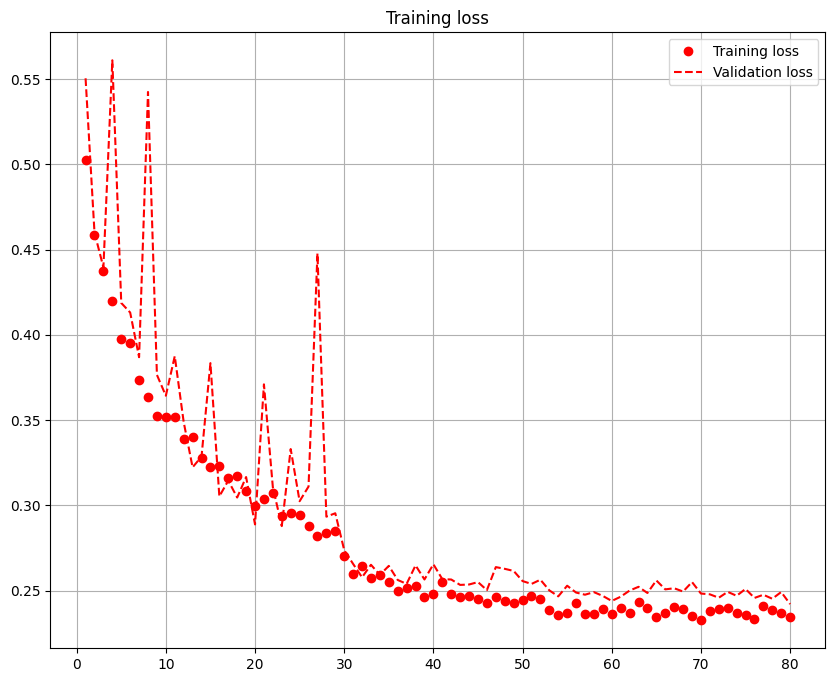

In [4]:
from torch.nn import CrossEntropyLoss
from torch.optim.adam import Adam



LEARNING_RATE = 0.001
EPOCHS = 80

segmenter = unet.load_unet(NUM_CLASSES, WaterSegmentationDataset.OUTPUT_SIZE[0])
segmenter = segmenter.to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(segmenter.parameters(), lr=LEARNING_RATE)
train_loss, validation_loss, train_accuracy, validation_accuracy = train_model(segmenter, EPOCHS, optimizer,
                                                                               criterion, 5)
utils.print_loss_history(train_loss, validation_loss)

For the training process, the **Adam** optimizer gave better results than **SGD**. **Adam** reached an accuracy above 0.94, whilst **SGD** reached an accuracy above 0.85

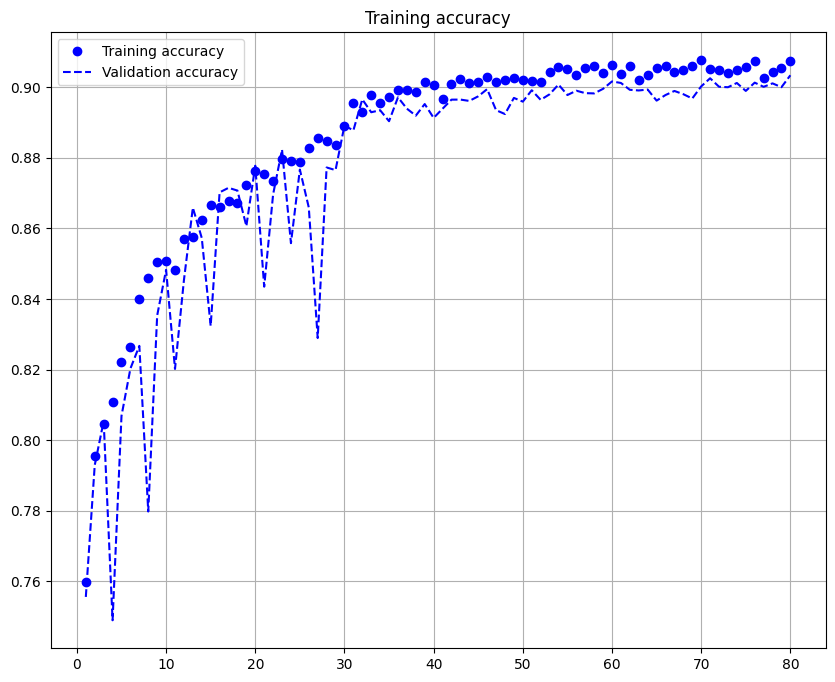

In [5]:
utils.print_accuracy_history(train_accuracy, validation_accuracy)

In [21]:
segmenter.load_state_dict(torch.load("checkpoints/unet_224_epoch54_0901.pth", weights_only=True))
print_model_performace(segmenter, testset)

Accuracy: 0.92189


One of the main problems of this model is that the images that contain no-data pixel values, that is  in the borders there are black pixels, the model classify those no-data values as water, impacting the performance of the model. Though, some posprocessing steps could be apply to the predicted masks to clean those false predictions.

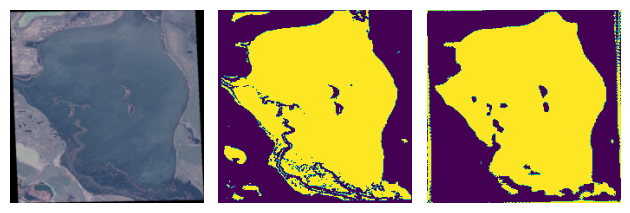

In [22]:
import matplotlib.pyplot as plt


def compare_prediction(index: int):
    segmenter.eval()
    with torch.no_grad():
        image, label = testset[index][0].to(device), testset[index][1].to(device)
        outputs = segmenter(image.unsqueeze(0))
    prediction = torch.max(outputs, dim=1)
    fig, axs = plt.subplots(1, 3, layout='tight')
    axs[0].imshow(image.permute((1, 2, 0)).cpu())
    axs[1].imshow(label.cpu() * 127)
    axs[2].imshow(prediction.indices.permute((1, 2, 0)).cpu() * 200)
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()
    fig.show()


compare_prediction(1)

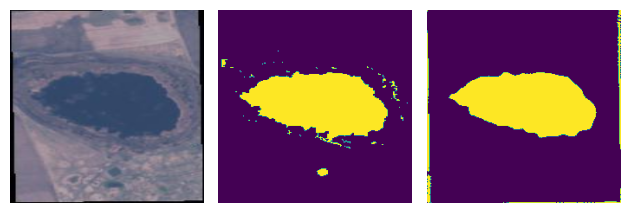

In [23]:
compare_prediction(6)

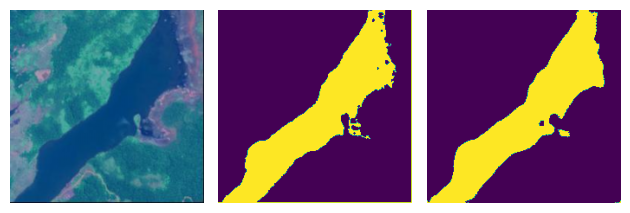

In [24]:
compare_prediction(7)